# Example
### __Multifold cross-validation for GP regression__

In [1]:
import random

import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch

# Import GP cross validation, metrics library, and utils function for QQ plot
import gp_diagnostics.cv as gp_cv
import gp_diagnostics.metrics as gp_metrics
from gp_diagnostics.utils.stats import snorm_qq

In [2]:
# DNV primary colors (for plotting)
clr = {
    "Sky blue": "#99d9f0",
    "Land green": "#3f9c35",
    "Sea blue": "#003591",
    "Dark blue": "#0f204b",
    "Cyan": "#009fda",
}

In [3]:
# Define GP model and helper functions for GP creation
class ExactGPModel(gpytorch.models.ExactGP):
    """
    Model for standard GP regression
    """

    def __init__(self, train_x, train_y, mean_module, covar_module, likelihood, path, name):
        super().__init__(train_x, train_y, likelihood)

        # For saving and loading
        self.path = path
        self.name = name
        self.param_fname = self.path + self.name + ".pth"

        # Mean and covariance functions
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def eval_mode(self):
        """
        Set model in evaluation mode
        """
        self.eval()
        self.likelihood.eval()

    def train_mode(self):
        """
        Set in training mode
        """
        self.train()
        self.likelihood.train()

    def predict(self, x, latent=True, CG_tol=0.1, full_cov=False):
        """
        Return mean and covariance at x

        Input:
        x         -      tensor of size dim * N containing N inputs
        latent    -      latent = True ->  using latent GP
                         latent = False -> using observed GP (incl. likelihood)
        CG_tol    -      Conjugate Gradient tolerance for evaluation
        full_cov  -      full_cov = False -> Return only diagonal (variances)

        Output:
        mean and covariance
        """

        with torch.no_grad(), gpytorch.settings.eval_cg_tolerance(CG_tol):
            # Latent distribution
            dist = self.__call__(x)

            # Observational distribution
            if not latent:
                dist = self.likelihood(dist)

            # Extract mean and covariance
            mean = dist.mean.cpu()
            var = dist.covariance_matrix.cpu() if full_cov else dist.variance.cpu()

            return mean, var

    def print_parameters(self):
        """
        Print actual (not raw) parameters
        """
        print("{:50} {}".format("Constant mean", self.mean_module.constant.item()))
        print("{:50} {}".format("Likelihood noise variance", self.likelihood.noise_covar.noise.item()))
        print("{:50} {}".format("Kernel lengthscale", self.covar_module.base_kernel.lengthscale.detach().numpy()[0]))
        print("{:50} {}".format("Kernel outputscale (variace)", self.covar_module.outputscale.item()))

    def save(self):
        """
        Save GP model parameters to self.path
        """
        print("Saving model to: ", self.param_fname)
        torch.save(self.state_dict(), self.param_fname)

    def load(self):
        """
        Load GP model parameters from self.path
        """
        print("Loading model from: ", self.param_fname)
        self.load_state_dict(torch.load(self.param_fname))


def gpytorch_kernel_Matern(var, ls, nu=2.5):
    """
    Return a Matern kernel with specified kernel variance (var) and lengthscales (ls)
    """
    ker_mat = gpytorch.kernels.MaternKernel(nu=nu, ard_num_dims=len(ls))
    ker_mat.lengthscale = ls
    ker = gpytorch.kernels.ScaleKernel(ker_mat)
    ker.outputscale = var

    return ker


def gpytorch_mean_constant(val, fixed=True):
    """
    Return a constant mean function

    fixed = True -> Do not update mean function during training
    """
    mean = gpytorch.means.ConstantMean()
    mean.initialize(constant=val)
    mean.constant.requires_grad = not fixed

    return mean


def gpytorch_likelihood_gaussian(variance, variance_lb=1e-6, fixed=True):
    """
    Return a Gaussian likelihood

    fixed = True -> Do not update during training
    variance_lb = lower bound
    """
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(variance_lb))
    likelihood.initialize(noise=variance)
    likelihood.requires_grad = not fixed

    return likelihood

First we generate some dummy data

In [4]:
# Generate data
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

N_DIM = 2  # the X dimension
N_TRAIN = 12

KER_SCALE_TRUE = 1.0
KER_LENGTHSCALE_TRUE = torch.ones(N_DIM + 1) * 0.5
KER_LENGTHSCALE_TRUE[-1] = KER_LENGTHSCALE_TRUE[-1] * 0.5  # Shorter lengthscale in the t-dimension

N_T_TRAIN = np.random.randint(
    5, 20, size=N_TRAIN
)  # Different number of observations in the t-dimension for each observed function

T_TRAIN = [np.linspace(np.random.uniform(0, 0.1), np.random.uniform(0.9, 1.0), n) for n in N_T_TRAIN]

X_TRAIN = np.array([[0.82, 0.88], [0.84, 0.81], [0.7, 0.22], [0.2, 0.6]])
X_TRAIN = np.append(X_TRAIN, np.random.uniform(size=(N_TRAIN - 4, N_DIM)), axis=0)

from_to = [0, *list(N_T_TRAIN.cumsum())]
FOLDS_INDICES = [list(range(from_to[i], from_to[i + 1])) for i in range(N_TRAIN)]

XT_TRAIN = np.zeros((N_T_TRAIN.sum(), N_DIM + 1))

XT_TRAIN = np.zeros((N_T_TRAIN.sum(), N_DIM + 1))

for i in range(N_TRAIN):
    XT_TRAIN[FOLDS_INDICES[i], 0:N_DIM] = X_TRAIN[i]
    XT_TRAIN[FOLDS_INDICES[i], -1] = T_TRAIN[i]

In [5]:
# Define kernel and sample training data
ker = gpytorch_kernel_Matern(KER_SCALE_TRUE, KER_LENGTHSCALE_TRUE)
K = ker(torch.tensor(XT_TRAIN, dtype=torch.float))
normal_rv = gpytorch.distributions.MultivariateNormal(mean=torch.zeros(K.shape[0]), covariance_matrix=K)

Y_TRAIN = normal_rv.sample()
YT_TRAIN = [Y_TRAIN[t_idx] for t_idx in FOLDS_INDICES]

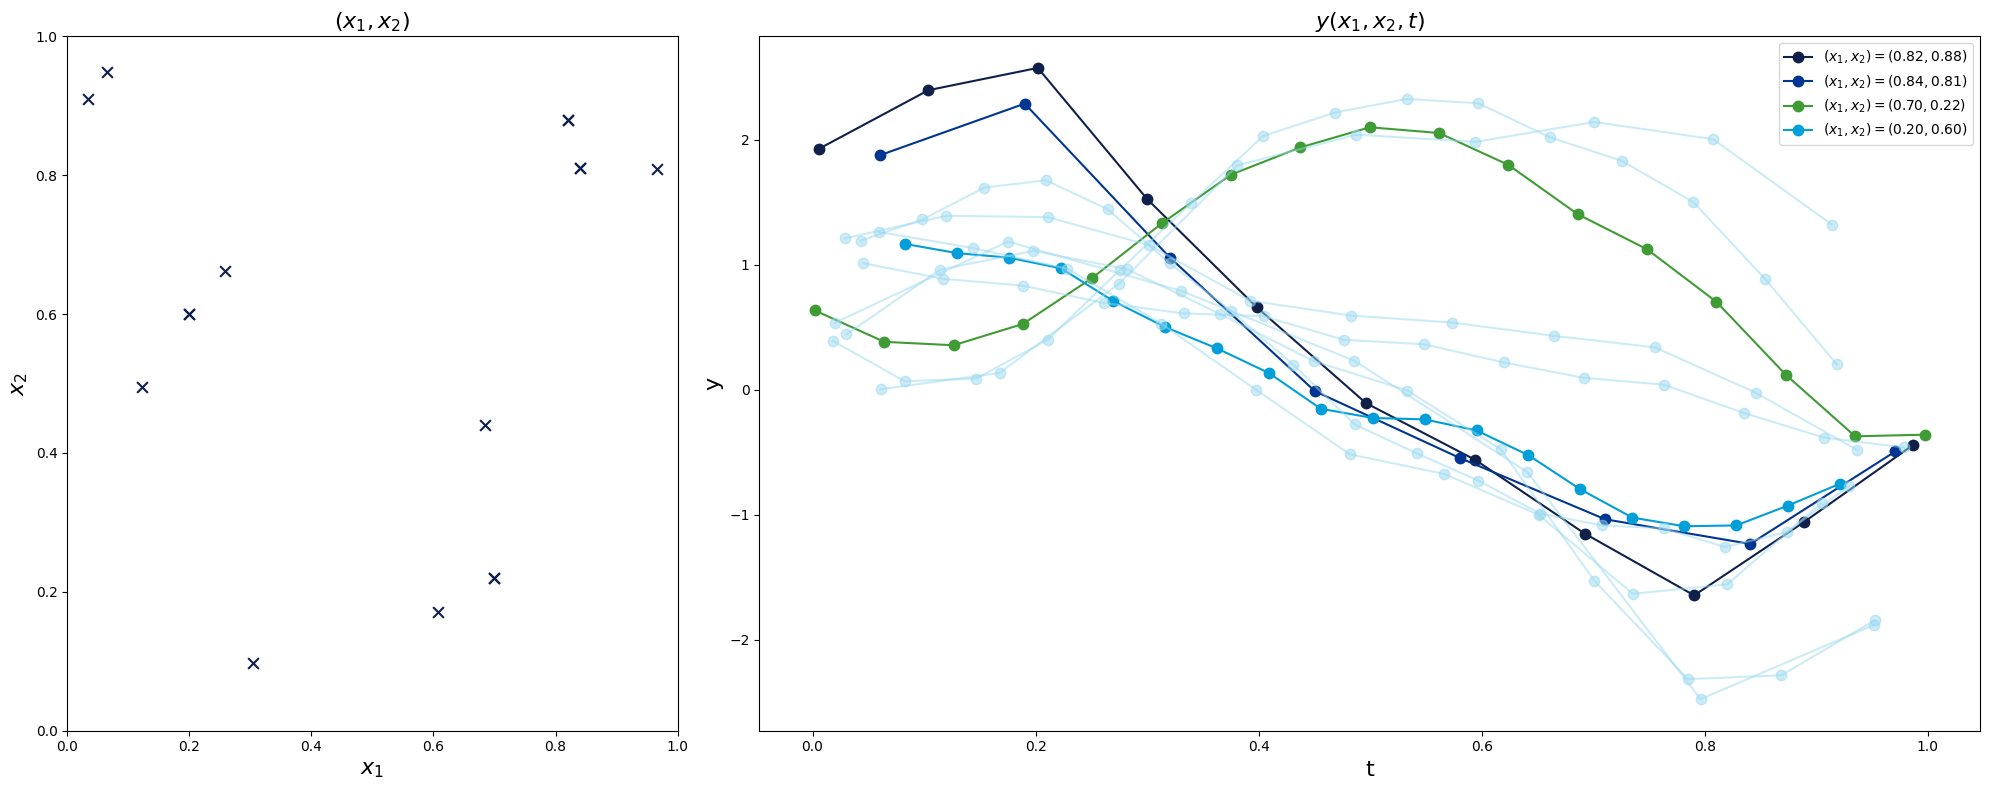

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8), gridspec_kw={"width_ratios": [1, 2]})
axs = axs.ravel()

# y(t)
ax = axs[1]
colors = [clr["Dark blue"], clr["Sea blue"], clr["Land green"], clr["Cyan"]]
for i in range(4):
    ax.plot(
        T_TRAIN[i],
        YT_TRAIN[i],
        marker=".",
        markersize=15,
        label=rf"$(x_1, x_2) = ({X_TRAIN[i][0]:.2f}, {X_TRAIN[i][1]:.2f})$",
        color=colors[i],
    )
for i in range(4, N_TRAIN):
    ax.plot(T_TRAIN[i], YT_TRAIN[i], marker=".", markersize=15, color=clr["Sky blue"], alpha=0.5)

ax.set_xlabel("t", fontsize=16)
ax.set_ylabel("y", fontsize=16)
ax.set_title(r"$y(x_1, x_2, t)$", fontsize=16)
ax.legend()

# x1, x2 - space
ax = axs[0]
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r"$x_1$", fontsize=16)
ax.set_ylabel(r"$x_2$", fontsize=16)
ax.set_title(r"$(x_1, x_2)$", fontsize=16)

for i in range(4):
    ax.scatter(X_TRAIN[i, 0], X_TRAIN[i, 1], marker="x", s=60, color=clr["Dark blue"])
ax.scatter(X_TRAIN[:, 0], X_TRAIN[:, 1], marker="x", s=60, color=clr["Dark blue"])

fig.tight_layout()

## LOO example

## 1) Fit a GP to some data

In [7]:
# Training data
X_Train = torch.tensor(T_TRAIN[2][::2].reshape(-1, 1), dtype=torch.float)
Y_Train = torch.tensor(YT_TRAIN[2][::2], dtype=torch.float)

# fig, ax = plt.subplots(figsize = (16, 8))

# ax.plot(X_Train, Y_Train, marker = '.', markersize = 15, color = clr['Dark blue'])
# ax.set_xlabel('t', fontsize = 16)
# ax.set_ylabel('y', fontsize = 16)
# ax.set_title(r'Training data', fontsize = 16)

C:\Users\MAGKRI\AppData\Local\Temp\ipykernel_28268\2435666669.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_Train = torch.tensor(YT_TRAIN[2][::2], dtype=torch.float)


In [8]:
# Fit GP
ker = gpytorch_kernel_Matern(KER_SCALE_TRUE, KER_LENGTHSCALE_TRUE[-1].reshape(1))
K = ker(X_Train)

model = ExactGPModel(
    X_Train,
    Y_Train,  # Training data
    gpytorch_mean_constant(0.0, fixed=True),  # Mean function
    ker,  # Kernel
    gpytorch_likelihood_gaussian(variance=1e-6, fixed=False),  # Likelihood
    "",
    "",
)  # Name and path for save/load

In [9]:
# Evaluate GP
model.eval_mode()

t = torch.linspace(0, 1, 100).reshape(-1, 1)
m, v = model.predict(t, latent=True, full_cov=True, CG_tol=0.001)

w, _ = np.linalg.eig(v)
min_eigval = w.min()
print(min_eigval)
jitter = abs(min_eigval * 2)
w, _ = np.linalg.eig(v + torch.eye(t.shape[0]) * jitter)
print(w.min())

samples = np.array(
    [
        gpytorch.distributions.MultivariateNormal(m, v + torch.eye(t.shape[0]) * jitter).sample().numpy()
        for _ in range(20)
    ]
)

(-5.601047e-07+0j)
(5.6013573e-07+0j)


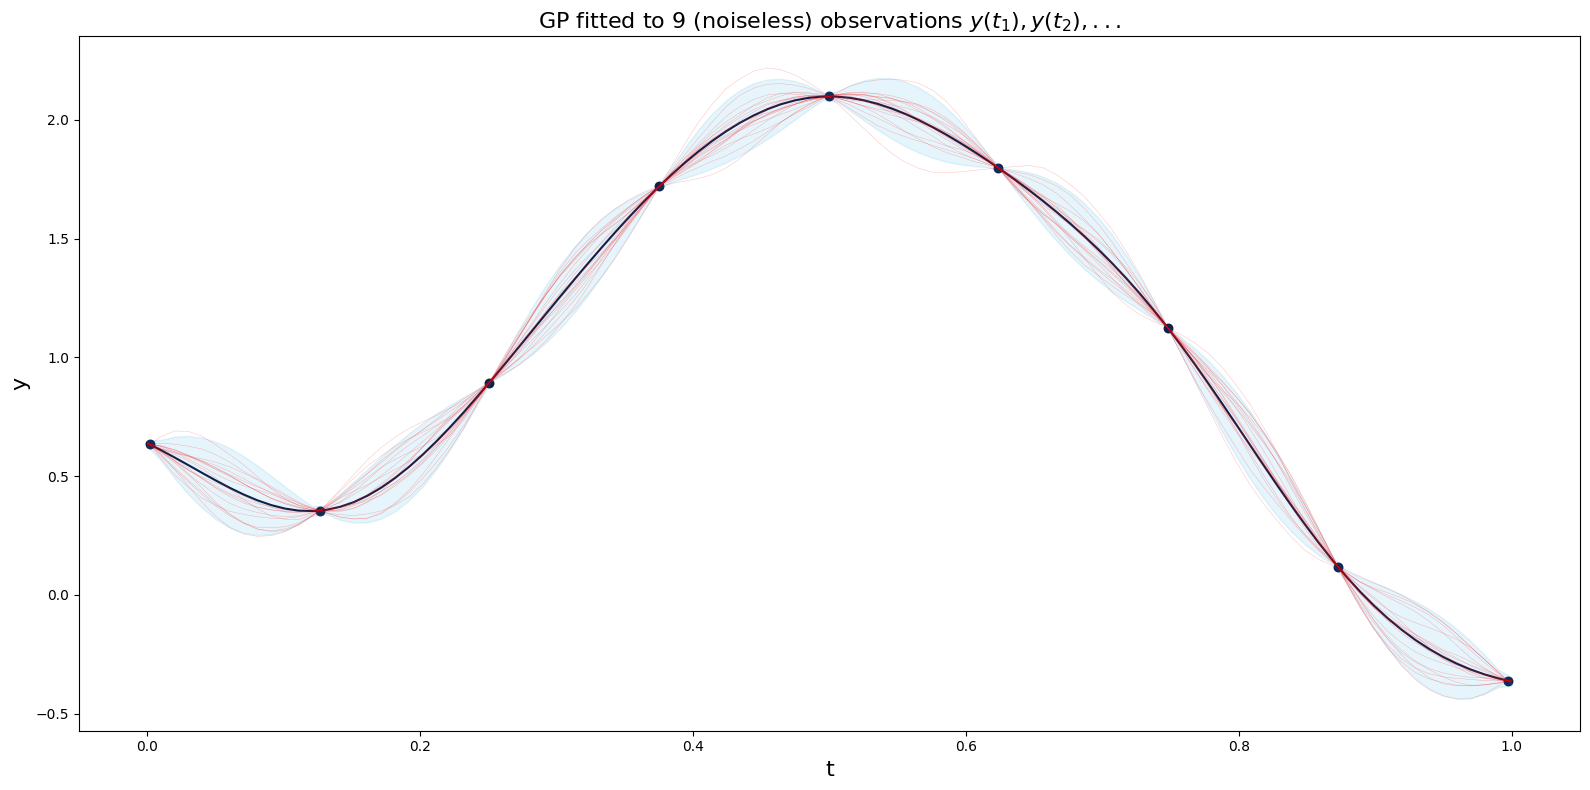

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.scatter(X_Train, Y_Train, marker=".", s=150, color=clr["Dark blue"])
ax.plot(t.flatten(), m, color=clr["Dark blue"])
ax.fill_between(t.flatten(), m - 2 * v.diagonal() ** 0.5, m + 2 * v.diagonal() ** 0.5, color=clr["Cyan"], alpha=0.1)
ax.set_xlabel("t", fontsize=16)
ax.set_ylabel("y", fontsize=16)
ax.set_title(rf"GP fitted to {Y_Train.shape[0]} (noiseless) observations $y(t_1), y(t_2), ...$", fontsize=16)

ax.plot(t, samples.T, color="red", alpha=0.3, linewidth=0.3)
fig.tight_layout()

## 2) Compute LOO errors

In [11]:
# To compute the LOO residuals we only need the covariance matrix and the training observations (converted to numpy arrays)
mean, cov, residuals_transformed = gp_cv.loo(K.numpy(), Y_Train.numpy(), noise_variance=0)

# 'residuals_transformed' is the residuals transformed to the standard normal space
# we will see that this is not the same normalizing the individual residuals (which will remain correlated)
residuals_scaled = mean / cov.diagonal() ** 0.5

In [12]:
# Function for plotting residuals
def plotres(ax, res, lbl=""):
    """
    Compute QQ plot of residuals 'res' and plot to ax
    """
    q_sample, q_snorm, q_snorm_upper, q_snorm_lower = snorm_qq(res)
    ax.scatter(q_snorm, q_sample, marker="o", facecolors="none", edgecolors="k")
    ax.plot(q_snorm_upper, q_sample, "k--")
    ax.plot(q_snorm_lower, q_sample, "k--")
    ax.set_xlabel("Theoretical quantiles")
    ax.set_ylabel("Sample quantiles")
    ax.set_title(f"Normal Q-Q Plot of {lbl}")
    line_min = min(q_snorm.min(), q_sample.min()) * 1.1
    line_max = max(q_snorm.max(), q_sample.max()) * 1.1
    ax.plot([line_min, line_max], [line_min, line_max], "k")
    ax.set_xlim(line_min, line_max)
    ax.set_ylim(line_min, line_max)

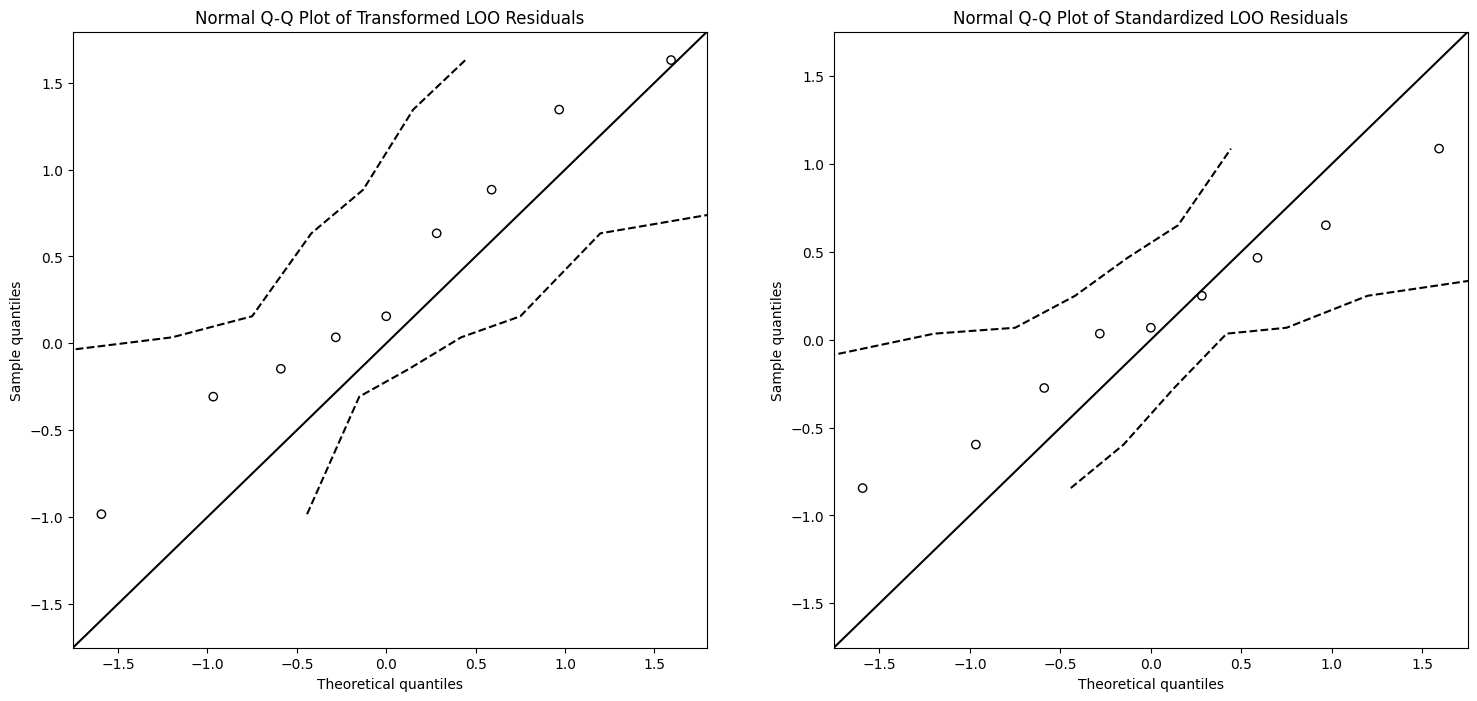

In [13]:
# Plot residuals
fig, axs = plt.subplots(ncols=2, figsize=(18, 8))
axs = axs.ravel()

plotres(axs[0], residuals_transformed, "Transformed LOO Residuals")
plotres(axs[1], residuals_scaled, "Standardized LOO Residuals")

In [14]:
metrics = gp_metrics.evaluate_GP(K.numpy(), Y_Train.numpy(), noise_variance=0)

for key in ["log_marginal_likelihood", "log_pseudo_likelihood", "MSE"]:
    print(key, metrics[key])

log_marginal_likelihood -5.6711862781147095
log_pseudo_likelihood -11.652355592851276
MSE 0.6070521939104224


# Multifold CV example

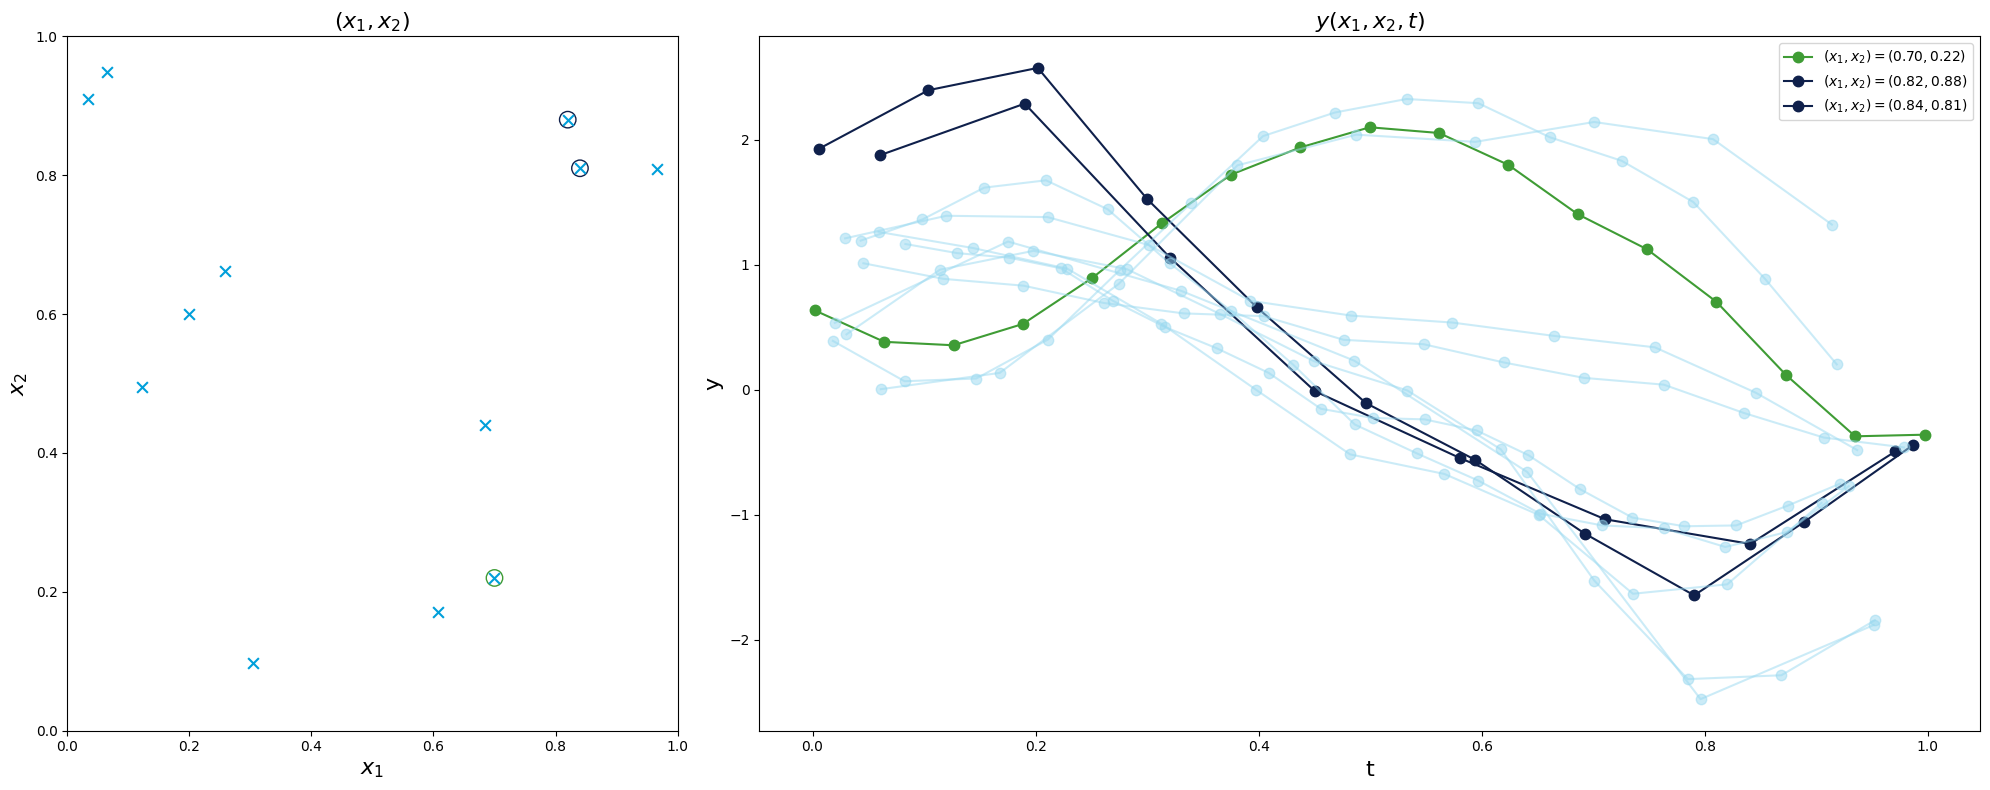

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8), gridspec_kw={"width_ratios": [1, 2]})
axs = axs.ravel()

# y(t)
ax = axs[1]
colors = [clr["Dark blue"], clr["Sea blue"], clr["Land green"], clr["Cyan"]]
i = 2
ax.plot(
    T_TRAIN[i],
    YT_TRAIN[i],
    marker=".",
    markersize=15,
    label=rf"$(x_1, x_2) = ({X_TRAIN[i][0]:.2f}, {X_TRAIN[i][1]:.2f})$",
    color=clr["Land green"],
)
for i in [0, 1]:
    ax.plot(
        T_TRAIN[i],
        YT_TRAIN[i],
        marker=".",
        markersize=15,
        label=rf"$(x_1, x_2) = ({X_TRAIN[i][0]:.2f}, {X_TRAIN[i][1]:.2f})$",
        color=clr["Dark blue"],
    )
for i in range(3, N_TRAIN):
    ax.plot(T_TRAIN[i], YT_TRAIN[i], marker=".", markersize=15, color=clr["Sky blue"], alpha=0.5)

ax.set_xlabel("t", fontsize=16)
ax.set_ylabel("y", fontsize=16)
ax.set_title(r"$y(x_1, x_2, t)$", fontsize=16)
ax.legend()

# x1, x2 - space
ax = axs[0]
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r"$x_1$", fontsize=16)
ax.set_ylabel(r"$x_2$", fontsize=16)
ax.set_title(r"$(x_1, x_2)$", fontsize=16)

i = 2
ax.scatter(X_TRAIN[i, 0], X_TRAIN[i, 1], marker="o", facecolors="none", edgecolors=clr["Land green"], s=140)

for i in [0, 1]:
    ax.scatter(X_TRAIN[i, 0], X_TRAIN[i, 1], marker="o", facecolors="none", edgecolors=clr["Dark blue"], s=140)

ax.scatter(X_TRAIN[:, 0], X_TRAIN[:, 1], marker="x", s=60, color=clr["Cyan"])

fig.tight_layout()

## 1) Compute GP covariance matrix from tranining inputs

In [16]:
X_Train = torch.tensor(XT_TRAIN, dtype=torch.float)
Y_Train = torch.tensor(torch.cat(YT_TRAIN), dtype=torch.float)

ker = gpytorch_kernel_Matern(KER_SCALE_TRUE, KER_LENGTHSCALE_TRUE)
K = ker(X_Train)

C:\Users\MAGKRI\AppData\Local\Temp\ipykernel_28268\1032232124.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_Train = torch.tensor(torch.cat(YT_TRAIN), dtype=torch.float)


## 2) Define folds

In [17]:
# Here, the folds are naturally given from the training data, as a "single observation" corresponds to
# observing the function y(t), at some some times t_1, t_2, ..., for one specific value of (x_1, x_2)
folds_startstop = np.array([0] + [Y.shape[0] for Y in YT_TRAIN]).cumsum()
folds = [list(range(folds_startstop[i], folds_startstop[i + 1])) for i in range(len(folds_startstop) - 1)]

print(f"There are a total of {len(folds)} folds with the following indices:")
display(folds)

There are a total of 12 folds with the following indices:


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [11, 12, 13, 14, 15, 16, 17, 18],
 [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54],
 [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
 [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81],
 [82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98],
 [99, 100, 101, 102, 103, 104, 105, 106, 107],
 [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118],
 [119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132],
 [133, 134, 135, 136, 137, 138, 139],
 [140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]]

## 3) Compute CV residuals

In [18]:
# To compute the LOO residuals we only need the covariance matrix and the training observations (converted to numpy arrays)
mean, cov, residuals_transformed = gp_cv.multifold(K.numpy(), Y_Train.numpy(), folds, noise_variance=0)

# 'residuals_transformed' is the residuals transformed to the standard normal space
# we will see that this is not the same normalizing the individual residuals (which will remain correlated)
residuals_scaled = mean / cov.diagonal() ** 0.5

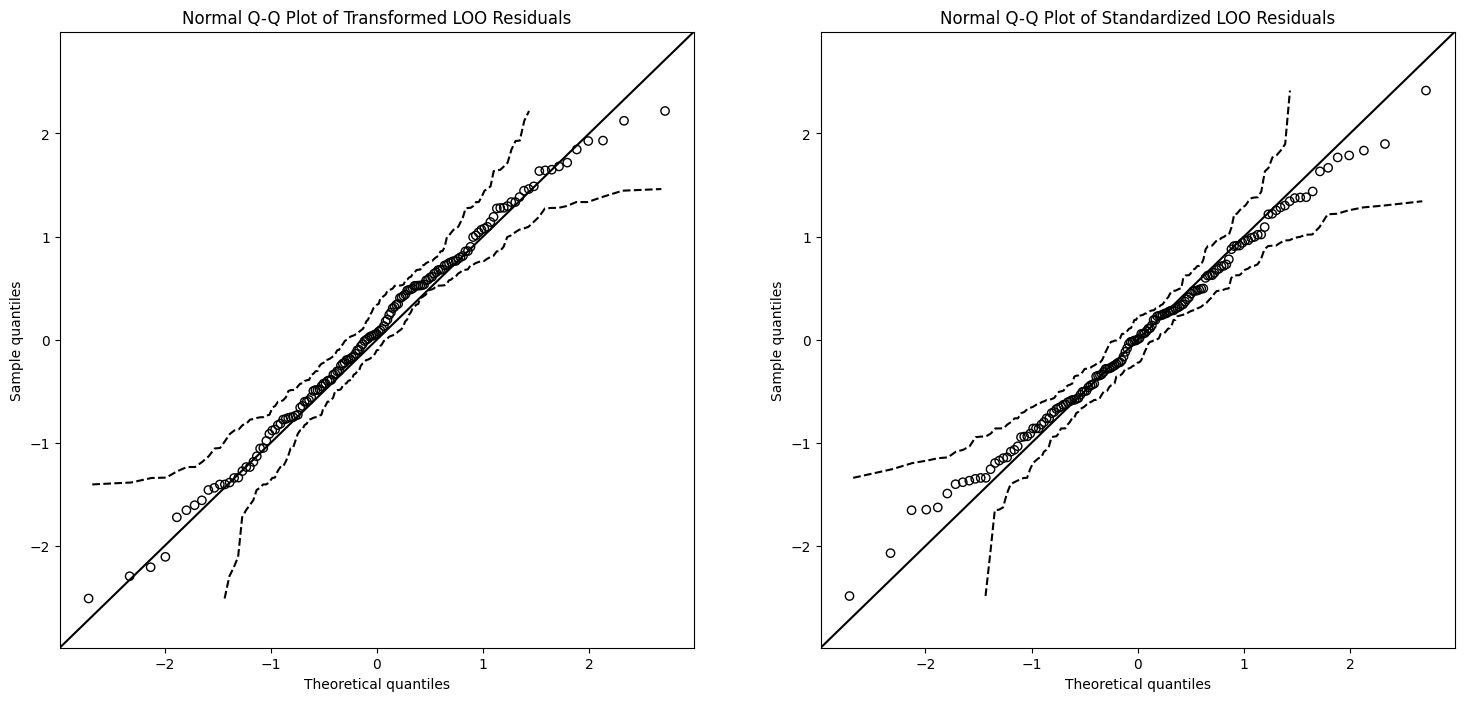

In [19]:
# Plot residuals
fig, axs = plt.subplots(ncols=2, figsize=(18, 8))
axs = axs.ravel()

plotres(axs[0], residuals_transformed, "Transformed LOO Residuals")
plotres(axs[1], residuals_scaled, "Standardized LOO Residuals")

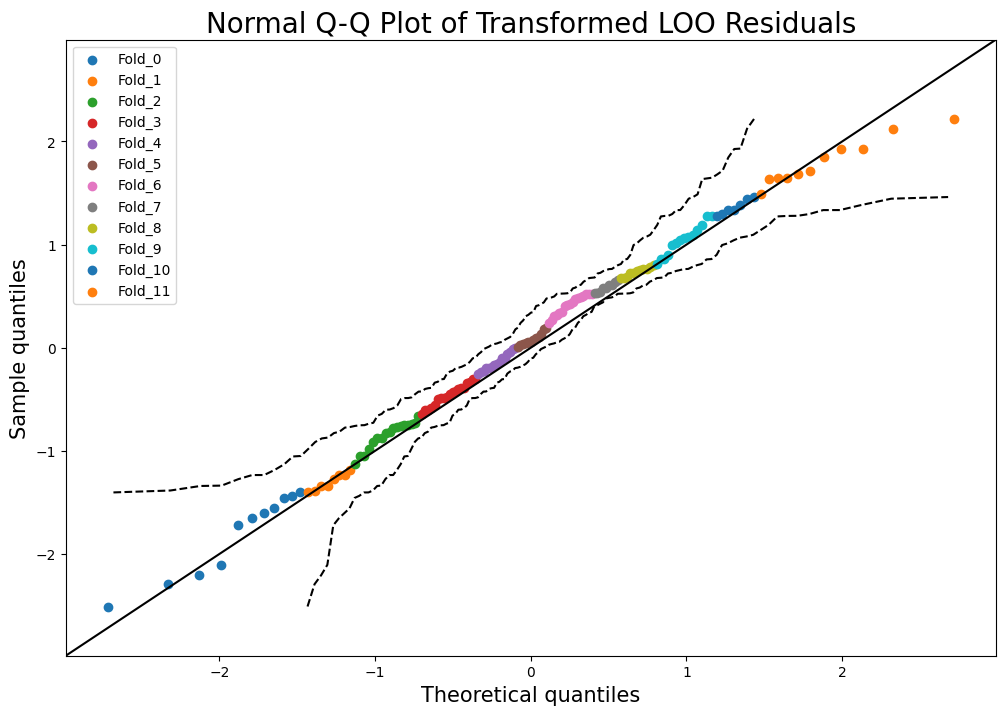

In [20]:
# Color by each fold
fig, ax = plt.subplots(figsize=(12, 8))

q_sample, q_snorm, q_snorm_upper, q_snorm_lower = snorm_qq(residuals_transformed)
ax.plot(q_snorm_upper, q_sample, "k--")
ax.plot(q_snorm_lower, q_sample, "k--")
ax.set_xlabel("Theoretical quantiles", fontsize=15)
ax.set_ylabel("Sample quantiles", fontsize=15)
ax.set_title("Normal Q-Q Plot of Transformed LOO Residuals", fontsize=20)
line_min = min(q_snorm.min(), q_sample.min()) * 1.1
line_max = max(q_snorm.max(), q_sample.max()) * 1.1
ax.plot([line_min, line_max], [line_min, line_max], "k")
ax.set_xlim(line_min, line_max)
ax.set_ylim(line_min, line_max)

for i in range(len(folds)):
    ax.scatter(q_snorm[folds[i]], q_sample[folds[i]], marker="o", label=f"Fold_{i}")

ax.legend()

# Use the 'metrics.evaluate_GP()' function to compute a set of relevant evaluation metrics

In [21]:
metrics = gp_metrics.evaluate_GP(K.numpy(), Y_Train.numpy(), folds, noise_variance=0)

for key in ["log_marginal_likelihood", "log_pseudo_likelihood", "MSE"]:
    print(key, metrics[key])

log_marginal_likelihood 77.63065384543853
log_pseudo_likelihood -211.50703924705886
MSE 1.9614453323941814


In [22]:
%timeit gp_metrics.evaluate_GP(K.numpy(), Y_Train.numpy(), folds, noise_variance = 0)

4.31 ms ± 75.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
